In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows import MaskedAutoregressiveFlow


from nflows.transforms import autoregressive
from torch.nn import functional as F
from nflows.flows.base import Flow
from nflows.transforms.permutations import RandomPermutation, ReversePermutation
from nflows.transforms import made as made_module
from nflows.transforms.base import CompositeTransform
from nflows.distributions.normal import StandardNormal
from nflows.utils import torchutils

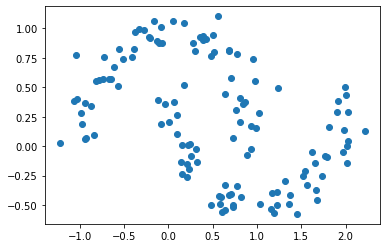

In [2]:
x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1]);

In [3]:
class InverseAutoregressiveFlow(autoregressive.AutoregressiveTransform):
    
    def forward(self, inputs, context=None):
        return super().inverse(inputs, context)
    
    def inverse(self, inputs, context=None):
        return super().forward(inputs, context)

In [4]:
class MaskedAffineInverseAutoregressiveTransform(InverseAutoregressiveFlow):
    def __init__(
        self,
        features,
        hidden_features,
        context_features=None,
        num_blocks=2,
        use_residual_blocks=True,
        random_mask=False,
        activation=F.relu,
        dropout_probability=0.0,
        use_batch_norm=False,
    ):
        self.features = features
        made = made_module.MADE(
            features=features,
            hidden_features=hidden_features,
            context_features=context_features,
            num_blocks=num_blocks,
            output_multiplier=self._output_dim_multiplier(),
            use_residual_blocks=use_residual_blocks,
            random_mask=random_mask,
            activation=activation,
            dropout_probability=dropout_probability,
            use_batch_norm=use_batch_norm,
        )
        self._epsilon = 1e-3
        super().__init__(made)

    def _output_dim_multiplier(self):
        return 2

    def _elementwise_forward(self, inputs, autoregressive_params):
        unconstrained_scale, shift = self._unconstrained_scale_and_shift(
            autoregressive_params
        )
        # scale = torch.sigmoid(unconstrained_scale + 2.0) + self._epsilon
        scale = F.softplus(unconstrained_scale) + self._epsilon
        log_scale = torch.log(scale)
        outputs = scale * inputs + shift
        logabsdet = torchutils.sum_except_batch(log_scale, num_batch_dims=1)
        return outputs, logabsdet

    def _elementwise_inverse(self, inputs, autoregressive_params):
        unconstrained_scale, shift = self._unconstrained_scale_and_shift(
            autoregressive_params
        )
        # scale = torch.sigmoid(unconstrained_scale + 2.0) + self._epsilon
        scale = F.softplus(unconstrained_scale) + self._epsilon
        log_scale = torch.log(scale)
        outputs = (inputs - shift) / scale
        logabsdet = -torchutils.sum_except_batch(log_scale, num_batch_dims=1)
        return outputs, logabsdet

    def _unconstrained_scale_and_shift(self, autoregressive_params):
        # split_idx = autoregressive_params.size(1) // 2
        # unconstrained_scale = autoregressive_params[..., :split_idx]
        # shift = autoregressive_params[..., split_idx:]
        # return unconstrained_scale, shift
        autoregressive_params = autoregressive_params.view(
            -1, self.features, self._output_dim_multiplier()
        )
        unconstrained_scale = autoregressive_params[..., 0]
        shift = autoregressive_params[..., 1]
        return unconstrained_scale, shift

In [5]:
class MaskedInverseAutoregressiveFlow(Flow):
    """An autoregressive flow that uses affine transforms with masking.

    Reference:
    > G. Papamakarios et al., Masked Autoregressive Flow for Density Estimation,
    > Advances in Neural Information Processing Systems, 2017.
    """

    def __init__(
            self,
            features,
            hidden_features,
            context_features=None,
            num_layers=5,
            num_blocks_per_layer=2,
            use_residual_blocks=True,
            use_random_masks=False,
            use_random_permutations=False,
            activation=F.relu,
            dropout_probability=0.0,
            batch_norm_within_layers=False,
            batch_norm_between_layers=False,
    ):

        if use_random_permutations:
            permutation_constructor = RandomPermutation
        else:
            permutation_constructor = ReversePermutation

        layers = []
        for _ in range(num_layers):
            layers.append(permutation_constructor(features))
            layers.append(
                MaskedAffineInverseAutoregressiveTransform(
                    features=features,
                    hidden_features=hidden_features,
                    context_features=context_features,
                    num_blocks=num_blocks_per_layer,
                    use_residual_blocks=use_residual_blocks,
                    random_mask=use_random_masks,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=batch_norm_within_layers,
                )
            )
            if batch_norm_between_layers:
                layers.append(BatchNorm(features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )

In [6]:
flow = MaskedInverseAutoregressiveFlow(features = 2, hidden_features = 4)
optimizer = optim.Adam(flow.parameters())

<ipython-input-7-11dc19d95c0f>:11: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /tmp/pip-req-build-mb0j4ret/aten/src/ATen/native/RangeFactories.cpp:23.)
  xline = torch.linspace(-1.5, 2.5)


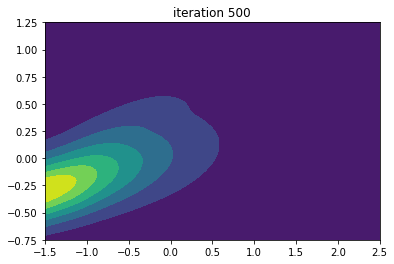

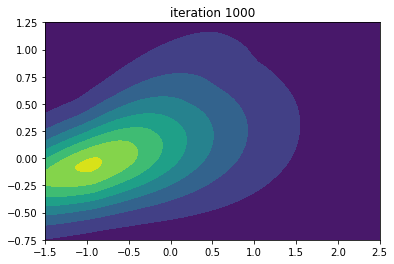

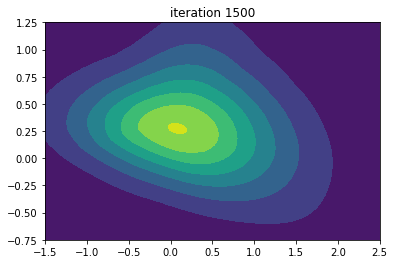

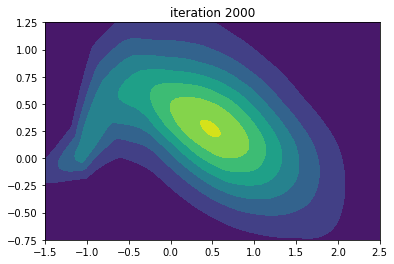

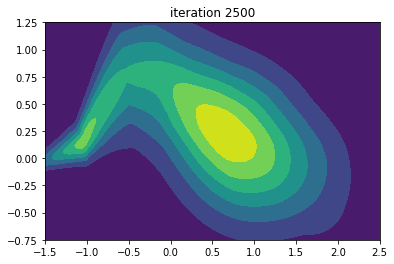

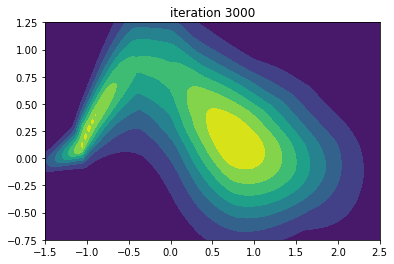

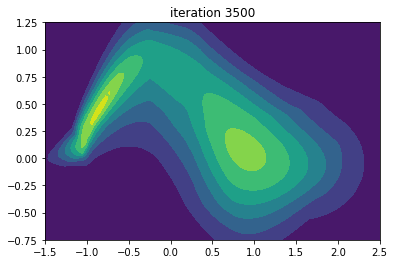

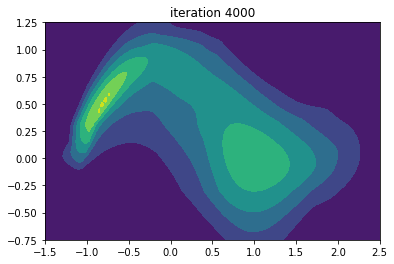

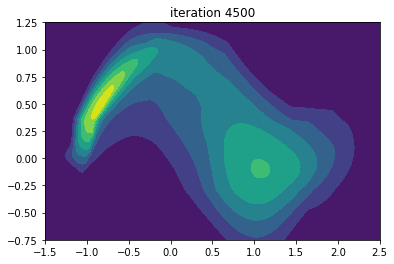

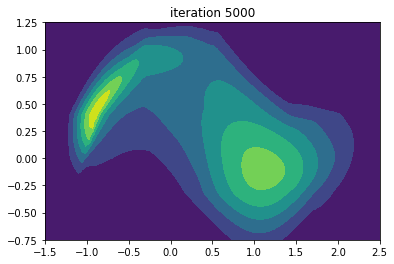

In [7]:
num_iter = 5000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        xline = torch.linspace(-1.5, 2.5)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()